In [1]:
import pymolpro as pmp
import os
import numpy as np
import pandas as pd
import math



def orbitalsize(orbital):
    return math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)]))

In [14]:
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
]
# Create the dictionary
geo_dt = {elements[i]: f'{i - 1}' for i in range(len(elements))}

# Print the dictionary
for element, value in geo_dt.items():
    print(f"{element}: {value}")

H: -1
He: 0
Li: 1
Be: 2
B: 3
C: 4
N: 5
O: 6
F: 7
Ne: 8


In [15]:

p_list=[]
for k,v in geo_dt.items():
    p=pmp.Project(f'{k}')
    p.write_input(f"""
    geometry={{{k}}}
    basis, aug-cc-pCv5Z
    set, charge={v}
    rhf
    {{CCSD;core,0}}
    put, xml
    """)
    p.run(wait=True)
    p_list.append(p)
    print(k)

H
He
Li
Be
B
C
N
O
F
Ne


In [4]:
p_list=[]
for k,v in geo_dt.items():
    p=pmp.Project(f'{k}')
    p_list.append(p)

H
3.0481589923159618
-0.03954018
He
1.0886859085051528
-0.0415734
Li
0.6673261676427464
-0.04292084
Be
0.481487869781748
-0.04363558
B
0.37667596154116445
-0.04402784
C
0.3093577872937707
-0.0442819
N
0.26246070980895503
-0.04446582
O
0.22791401416106183
-0.0445856
F
0.20140565904742472
-0.0446812
Ne
0.18042212390993212
-0.04470568


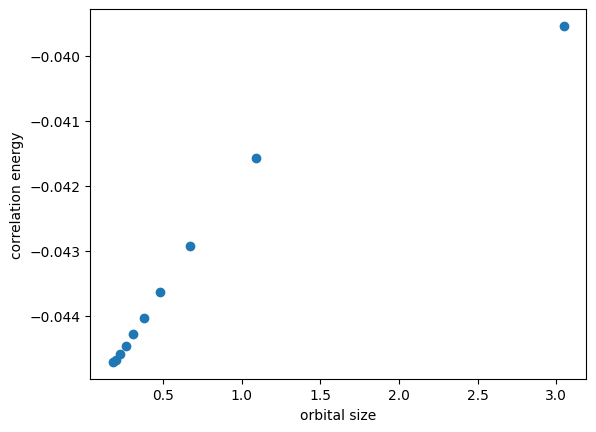

<Figure size 640x480 with 0 Axes>

In [34]:
size_list=[]
corr_list=[]
energy_list=[]
weird=[]

for p in p_list:
    print(p.name)
    for orbital in p.orbitals():
        size_list.append(orbitalsize(orbital))
        print(size_list[-1])
        energy_list.append(float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]))
        weird.append(math.log10(abs(energy_list[-1])/size_list[-1]**3))
    #there's only a single pair with two entries
    e=0
    for pair in p.xpath('//pair'):
        tmp=pmp.element_to_dict(pair)
        e=e+float(tmp['energy'])
        
    print(e)
    corr_list.append(e)

mean = np.mean(size_list)
std = np.std(size_list)
normalised=[(i-mean)/std for i in size_list]

cmean = np.mean(corr_list)
cstd = np.std(corr_list)
cnormalised=[(i-mean)/std for i in corr_list]
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(size_list,corr_list)
plt.xlabel('orbital size')
plt.ylabel('correlation energy')
plt.show()
plt.savefig('sizeenergy2elec.png')

Epoch 1/50
10/10 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 2/50
10/10 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 3/50
10/10 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4/50
10/10 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 5/50
10/10 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 6/50
10/10 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7/50
10/10 [==============================] - 0s 1ms/step - loss: 5.8885e-04
Epoch 8/50
10/10 [==============================] - 0s 1ms/step - loss: 2.4728e-04
Epoch 9/50
10/10 [==============================] - 0s 1ms/step - loss: 8.5286e-05
Epoch 10/50
10/10 [==============================] - 0s 1ms/step - loss: 3.3081e-05
Epoch 11/50
10/10 [==============================] - 0s 1ms/step - loss: 1.0277e-05
Epoch 12/50
10/10 [==============================] - 0s 1ms/step - loss: 5.1296e-06
Epoch 13/50
10/10 [======

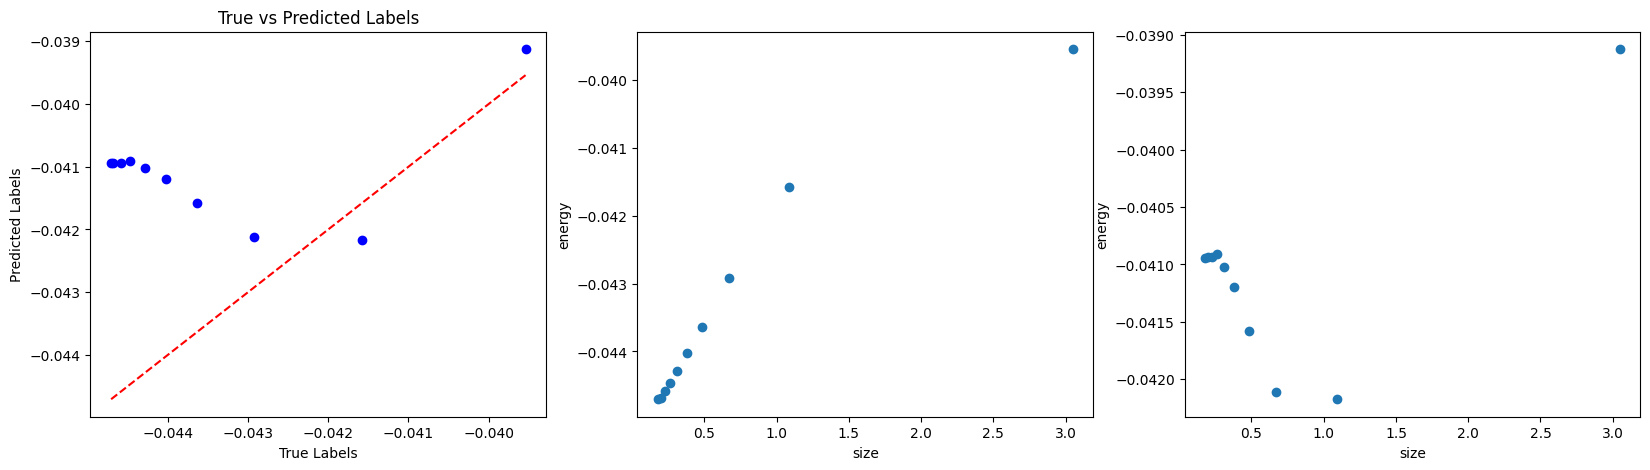

In [18]:
import tensorflow as tf
import keras



batch_size=15

features=np.array(size_list)
features=np.reshape(features,(len(corr_list),1))
labels=np.array(corr_list)
labels=np.reshape(labels,(len(corr_list),1))

mean = np.mean(features)
std = np.std(features)
features = (features - mean) / std

dataset=tf.data.Dataset.from_tensor_slices((features,labels))




model=keras.Sequential([
    keras.layers.Input(shape=(1,)),
    keras.layers.Dense(500,activation='relu'),
    keras.layers.Dense(1,)
])

model.compile('Adam',loss='mse')
model.fit(dataset,epochs=50)


model.save('size.keras')

predictions = model.predict(np.array(size_list))


import matplotlib as mpl
import matplotlib.pyplot as plt

test_labels = []
for features, labels in dataset:
    test_labels.append(labels.numpy())
error=sum([abs((predictions[i]-test_labels[i])/test_labels[i])for i in range(len(predictions))])
print(error)
test_labels = np.concatenate(test_labels, axis=0)
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].scatter(test_labels, predictions, c='blue')
ax[0].plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Line for y=x
ax[0].set_xlabel('True Labels')
ax[0].set_ylabel('Predicted Labels')
ax[0].set_title('True vs Predicted Labels')

ax[1].scatter(size_list,corr_list)
ax[1].set_xlabel('size')
ax[1].set_ylabel('energy')

ax[2].scatter(size_list,predictions)
ax[2].set_xlabel('size')
ax[2].set_ylabel('energy')
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')

In [20]:
def buildmodel(act,loss):
    model=keras.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(64,activation=act),
        keras.layers.Dense(1,)
    ])
    model.compile(
        'Adam',
        loss=loss)
    return model

act_funcs=['relu','selu','tanh','sigmoid','gelu']
loss=['mse','mae','mape','huber']

result_dt=[]

q=0
for i in act_funcs:
    for j in loss:
        model=buildmodel(i,j)
        model.fit(dataset,epochs=25)
        tmp=np.array(model.predict(size_list))
        result_dt.append({'params':{i,j},'predictions':tmp})


        

Epoch 1/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0362
Epoch 2/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0174
Epoch 3/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 4/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 5/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 6/25
10/10 [==============================] - 0s 1ms/step - loss: 5.8300e-04
Epoch 7/25
10/10 [==============================] - 0s 1ms/step - loss: 2.9582e-04
Epoch 8/25
10/10 [==============================] - 0s 1ms/step - loss: 2.4592e-04
Epoch 9/25
10/10 [==============================] - 0s 1ms/step - loss: 2.3120e-04
Epoch 10/25
10/10 [==============================] - 0s 1ms/step - loss: 2.1231e-04
Epoch 11/25
10/10 [==============================] - 0s 1ms/step - loss: 1.9323e-04
Epoch 12/25
10/10 [==============================] - 0s 1ms/step - loss: 1.7544e-04
Epoch 13/25
10/10 [==

1/1 [==============================] - 0s 94ms/step
Epoch 1/25
10/10 [==============================] - 0s 1ms/step - loss: 0.1046
Epoch 2/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 3/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0346
Epoch 4/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 5/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 6/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 7/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 8/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 9/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 10/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 11/25
10/10 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 12/25
10/10 [==============================] - 0s 1ms/step - loss: 0.00

1/1 [==============================] - 0s 47ms/step
Epoch 1/25
10/10 [==============================] - 1s 1ms/step - loss: 241.0449
Epoch 2/25
10/10 [==============================] - 0s 1ms/step - loss: 82.7140
Epoch 3/25
10/10 [==============================] - 0s 1ms/step - loss: 63.9879
Epoch 4/25
10/10 [==============================] - 0s 1ms/step - loss: 41.3030
Epoch 5/25
10/10 [==============================] - 0s 1ms/step - loss: 20.5070
Epoch 6/25
10/10 [==============================] - 0s 1ms/step - loss: 31.3443
Epoch 7/25
10/10 [==============================] - 0s 1ms/step - loss: 35.6384
Epoch 8/25
10/10 [==============================] - 0s 1ms/step - loss: 11.6549
Epoch 9/25
10/10 [==============================] - 0s 1ms/step - loss: 32.8932
Epoch 10/25
10/10 [==============================] - 0s 1ms/step - loss: 9.8967
Epoch 11/25
10/10 [==============================] - 0s 1ms/step - loss: 30.4630
Epoch 12/25
10/10 [==============================] - 0s 1ms/step -

NameError: name 'reults_dt' is not defined

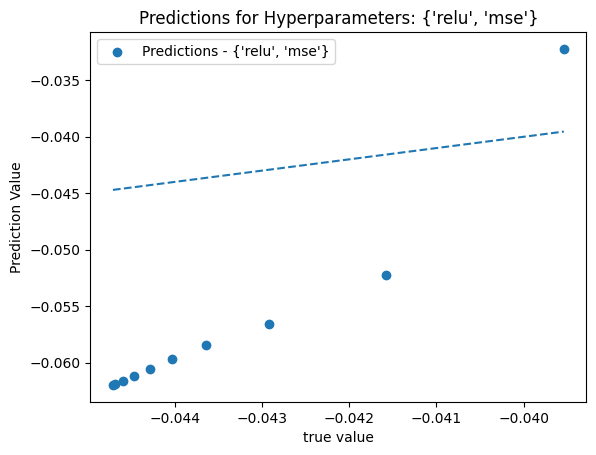

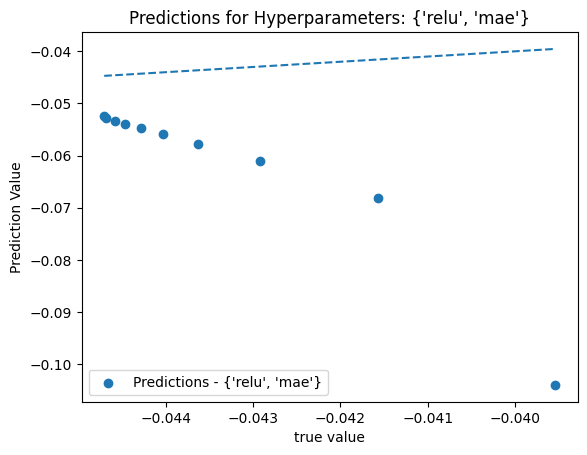

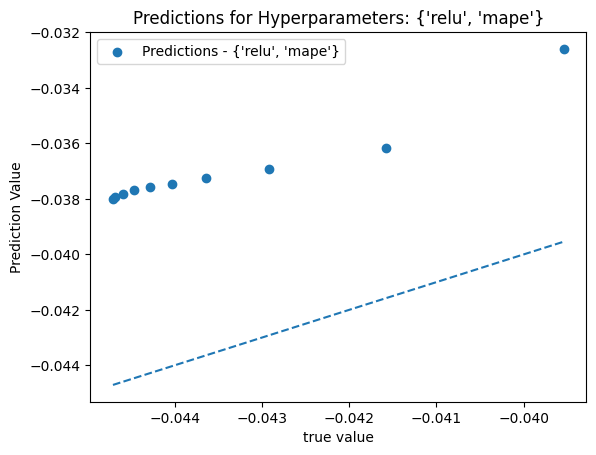

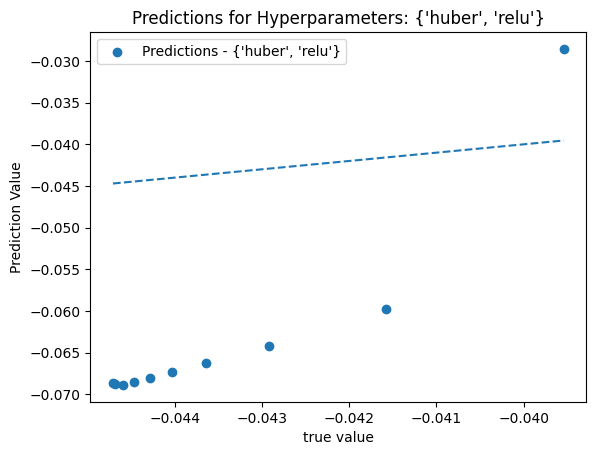

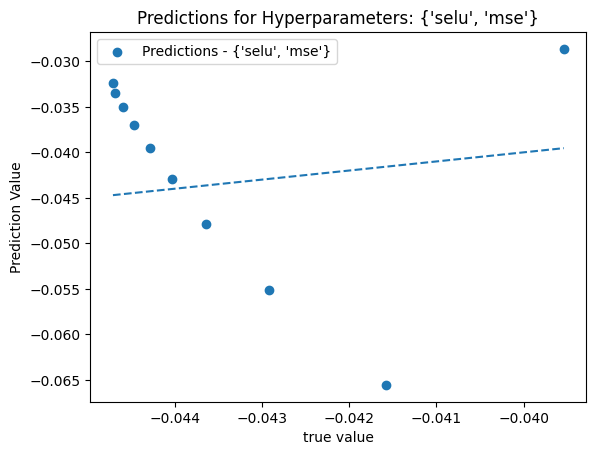

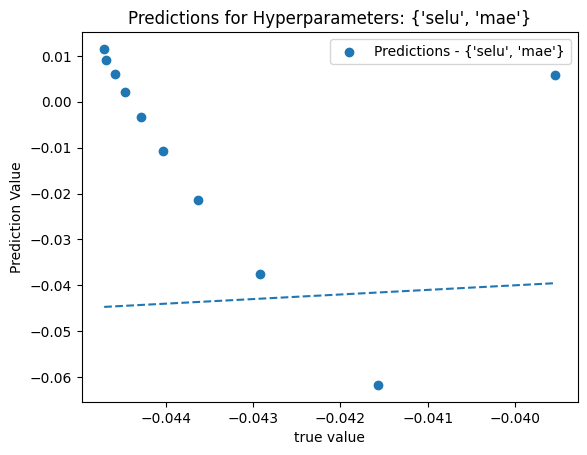

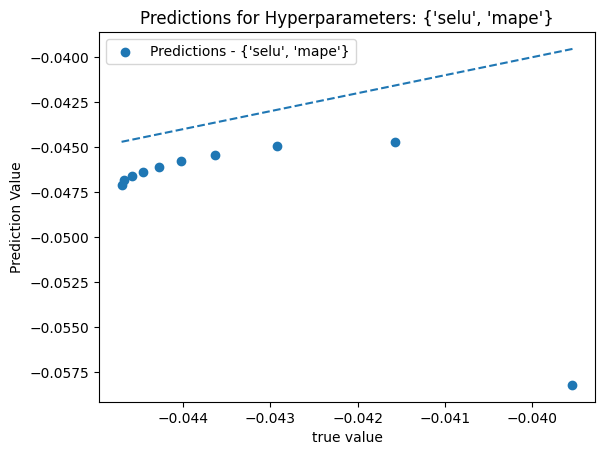

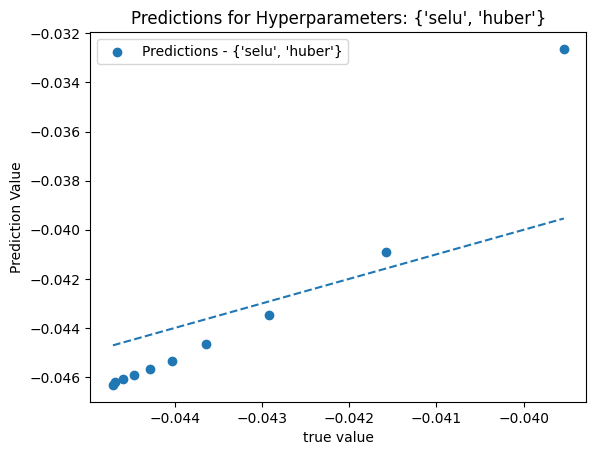

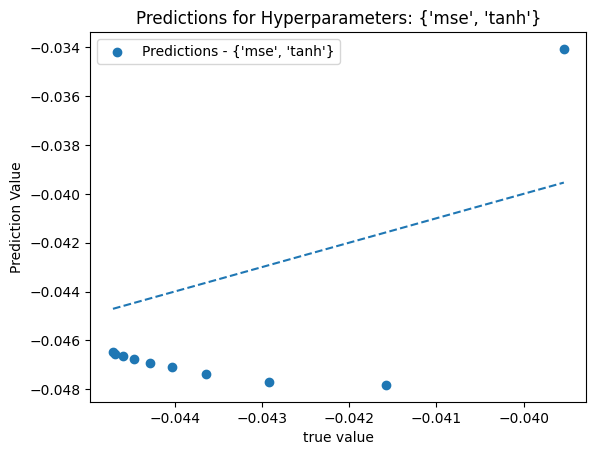

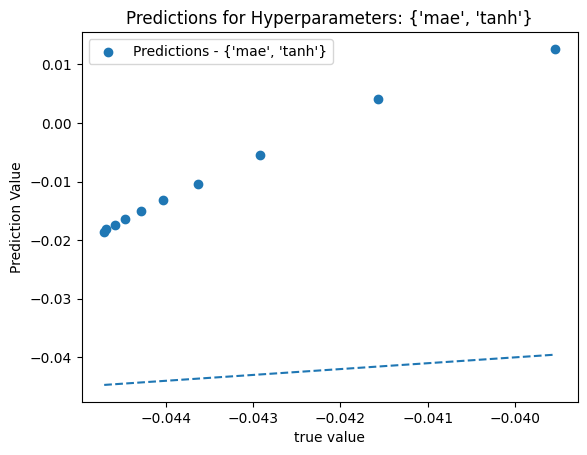

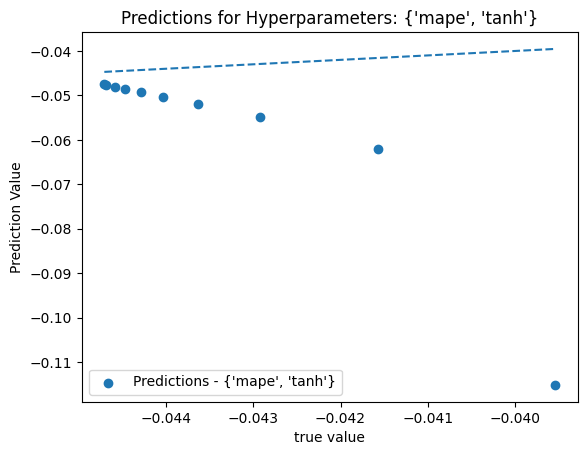

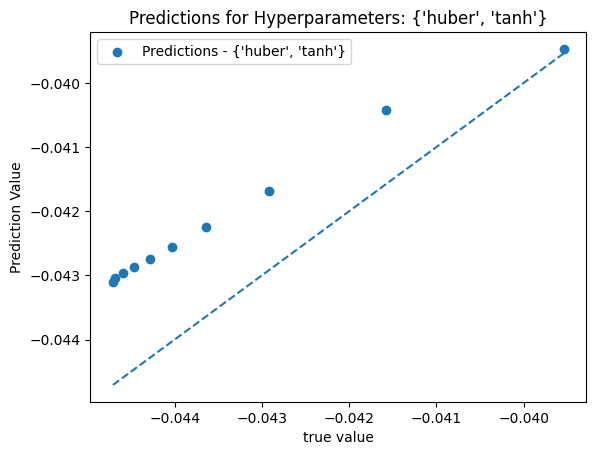

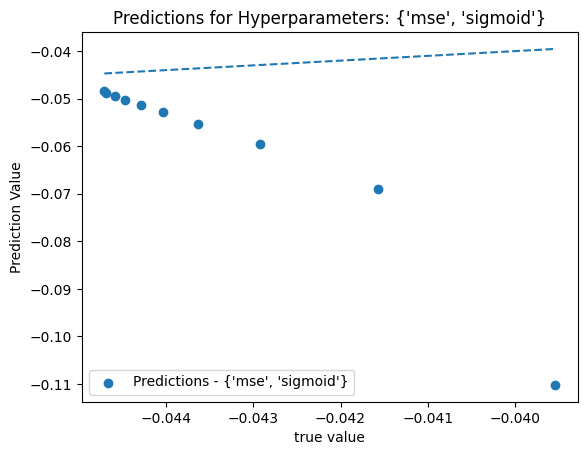

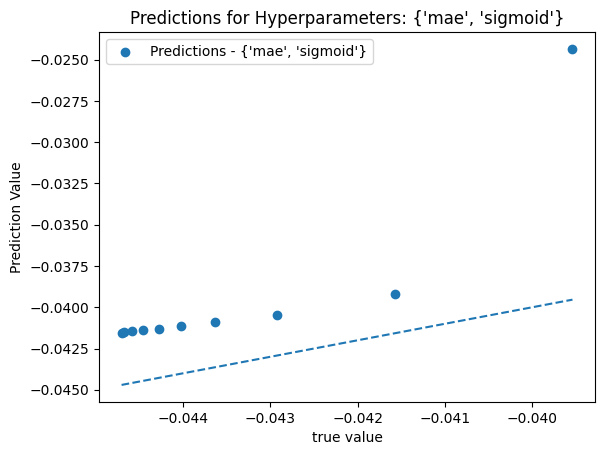

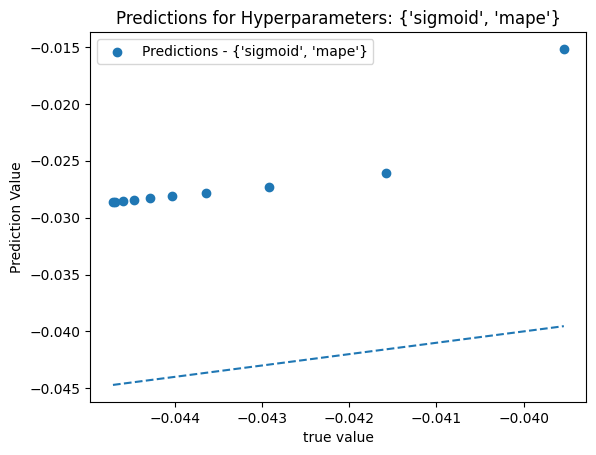

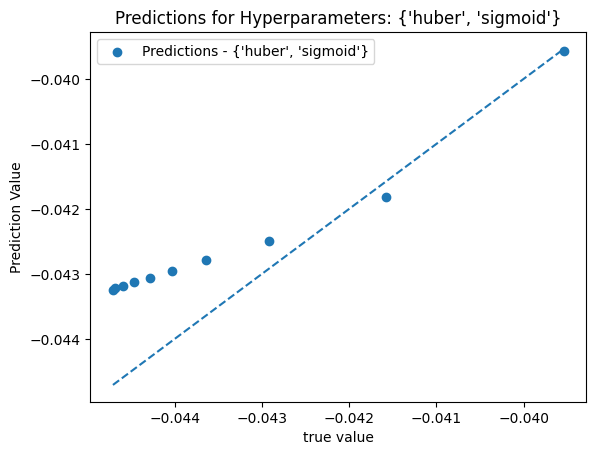

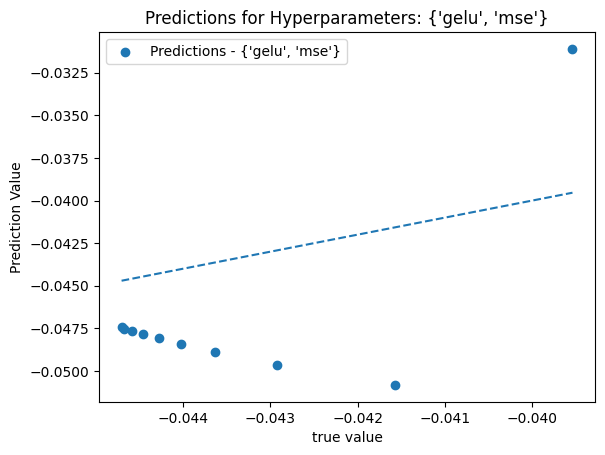

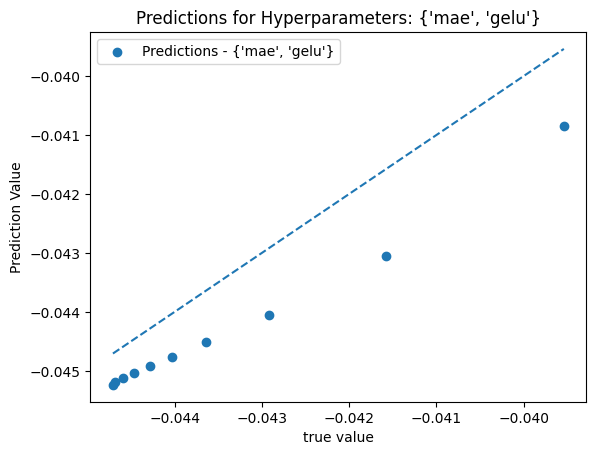

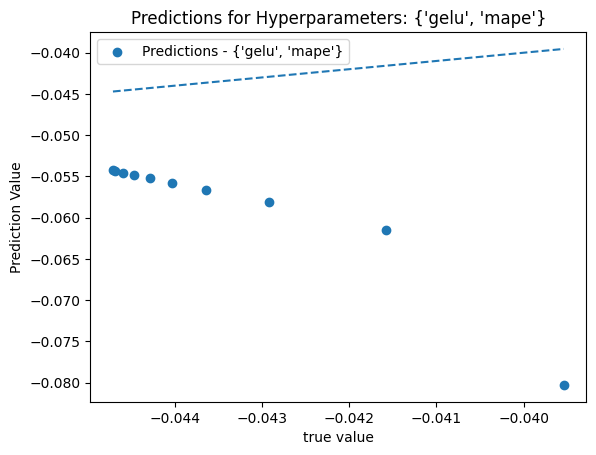

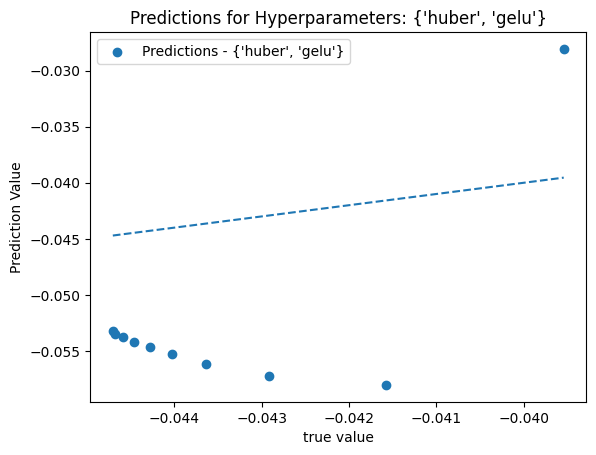

In [29]:
for i,results in enumerate(result_dt):
    plt.figure(i)
    plt.scatter(corr_list, results['predictions'], label=f"Predictions - {results['params']}")
    plt.title(f"Predictions for Hyperparameters: {results['params']}")
    plt.plot((min(corr_list),max(corr_list)),(min(corr_list),max(corr_list)),linestyle='--')
    plt.xlabel("true value")
    plt.ylabel("Prediction Value")
    plt.legend()
    plt.show()
    
        

                  

Epoch 1/30
10/10 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 2/30
10/10 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 3/30
10/10 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 4/30
10/10 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 5/30
10/10 [==============================] - 0s 1ms/step - loss: 9.5065e-04
Epoch 6/30
10/10 [==============================] - 0s 1ms/step - loss: 6.7957e-04
Epoch 7/30
10/10 [==============================] - 0s 1ms/step - loss: 5.1452e-04
Epoch 8/30
10/10 [==============================] - 0s 1ms/step - loss: 4.0240e-04
Epoch 9/30
10/10 [==============================] - 0s 1ms/step - loss: 2.9730e-04
Epoch 10/30
10/10 [==============================] - 0s 1ms/step - loss: 2.1086e-04
Epoch 11/30
10/10 [==============================] - 0s 1ms/step - loss: 1.4961e-04
Epoch 12/30
10/10 [==============================] - 0s 1ms/step - loss: 1.0619e-04
Epoch 13/30
10/10

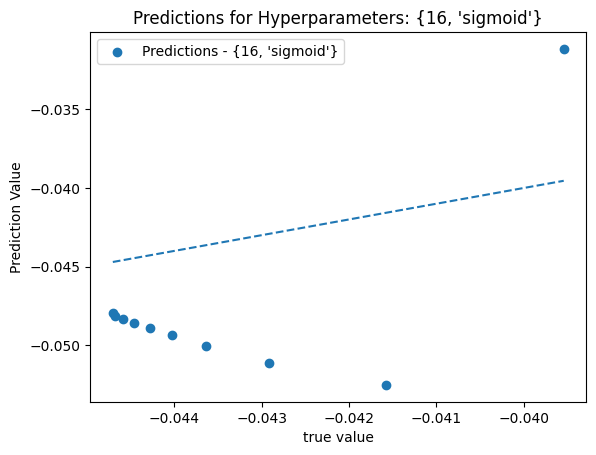

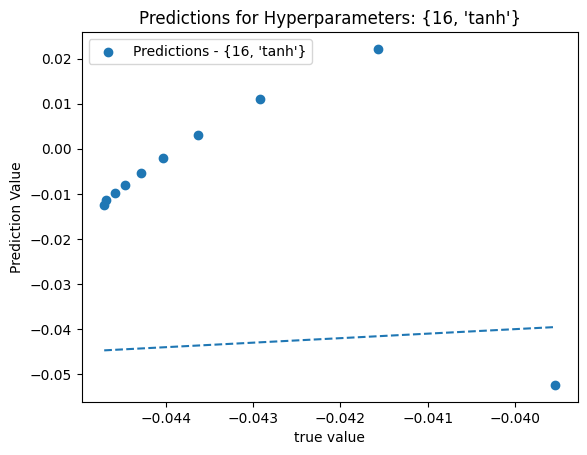

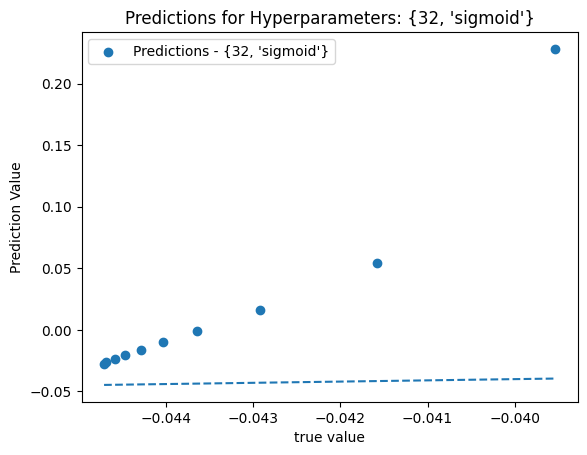

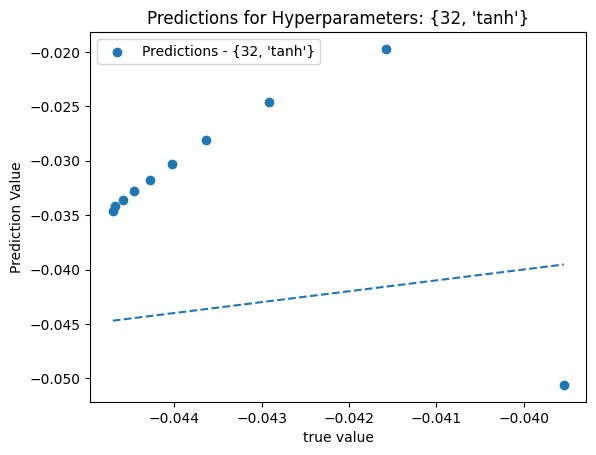

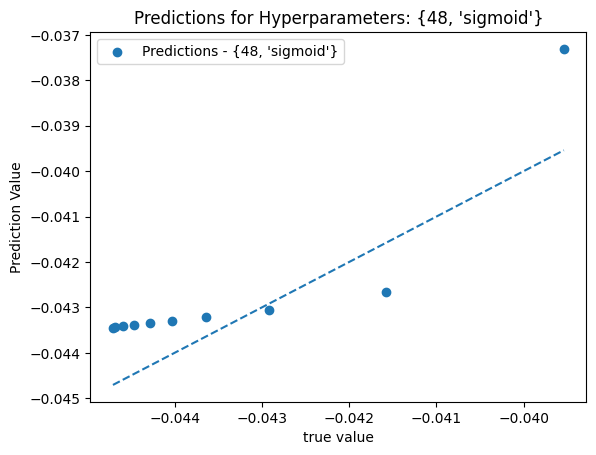

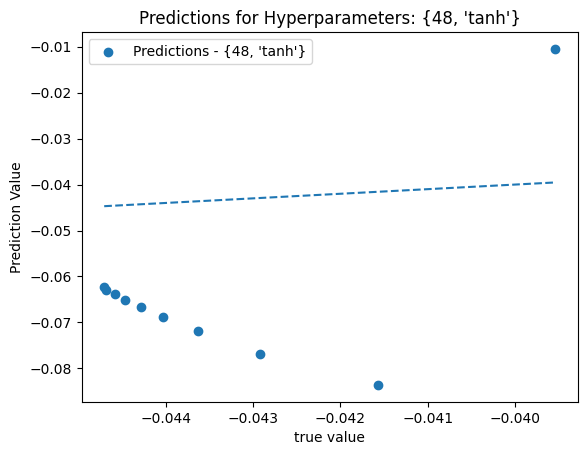

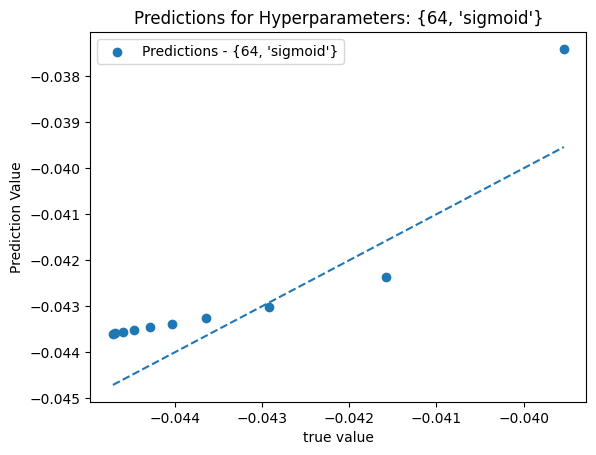

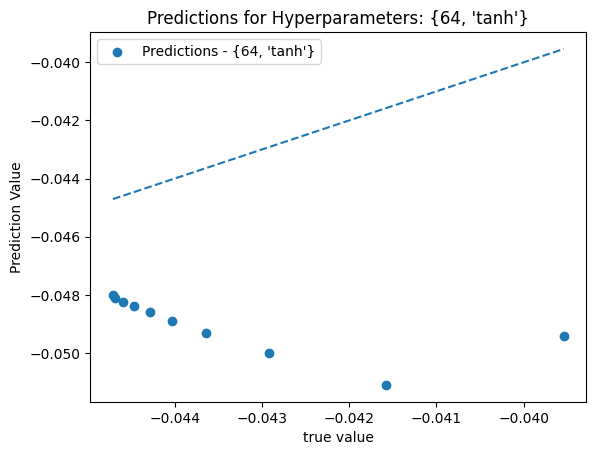

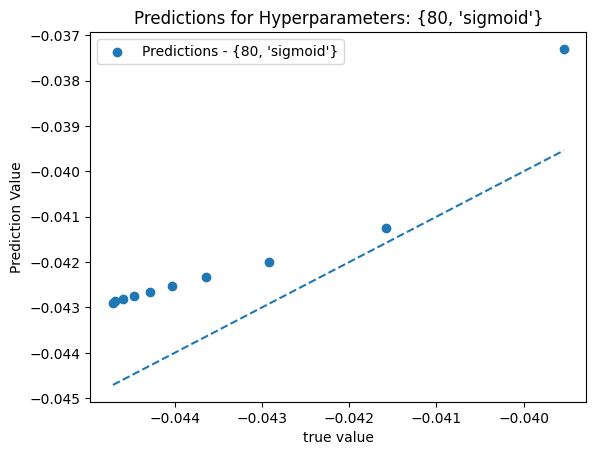

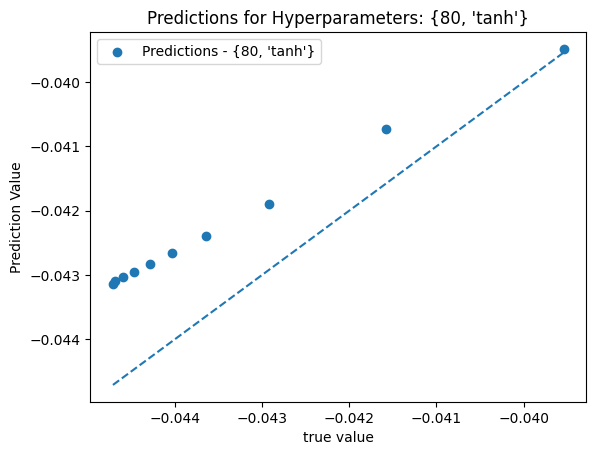

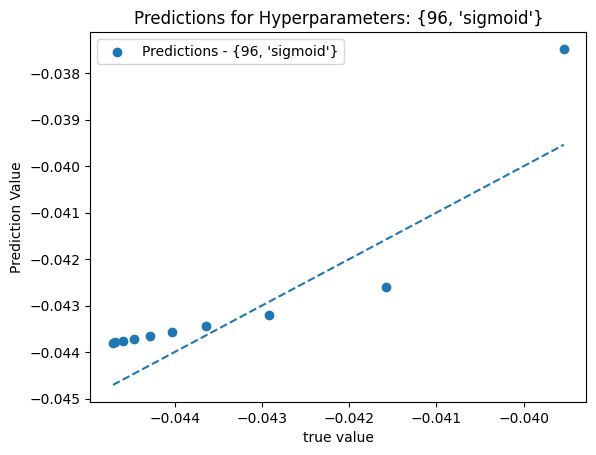

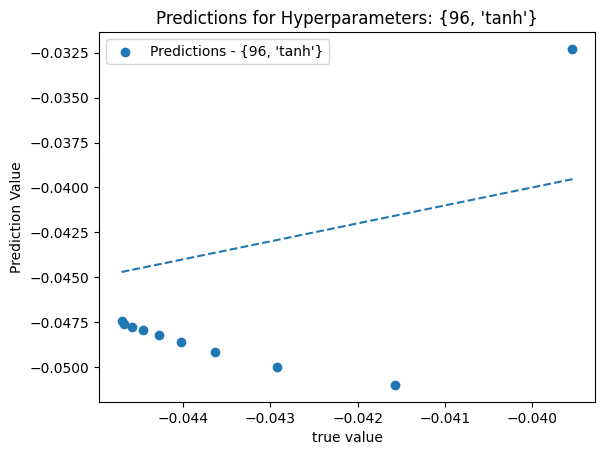

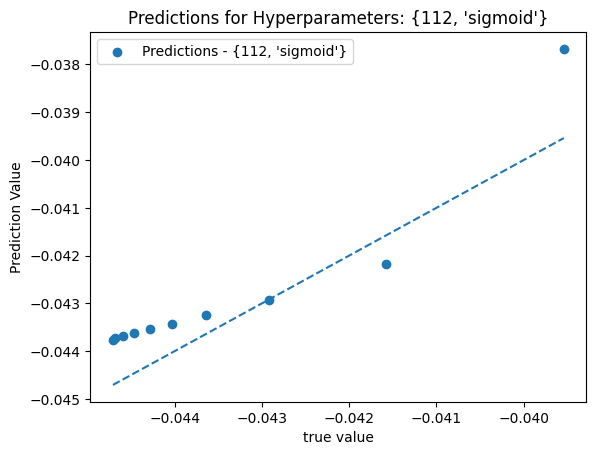

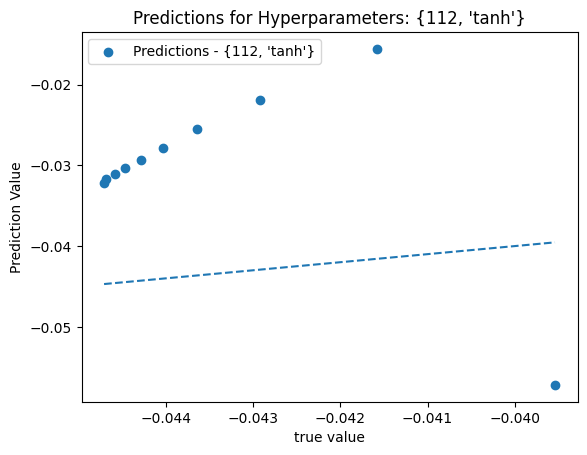

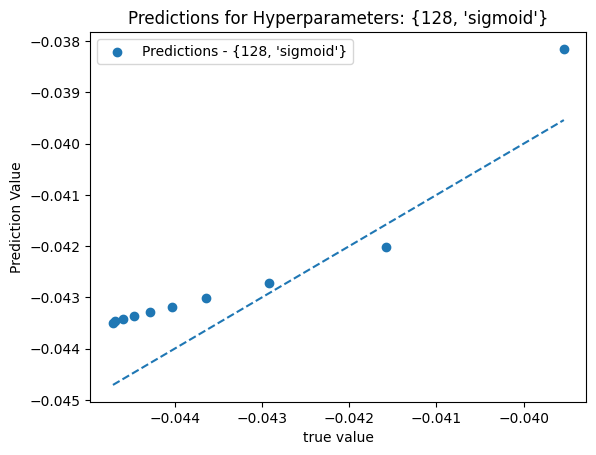

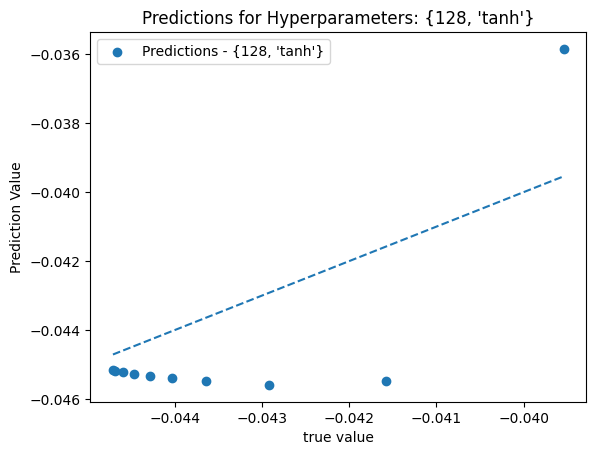

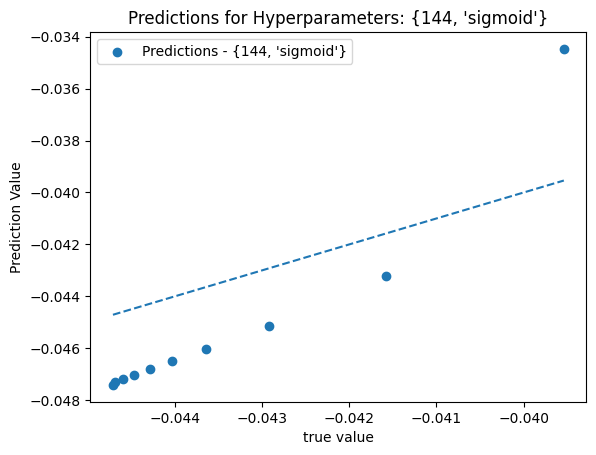

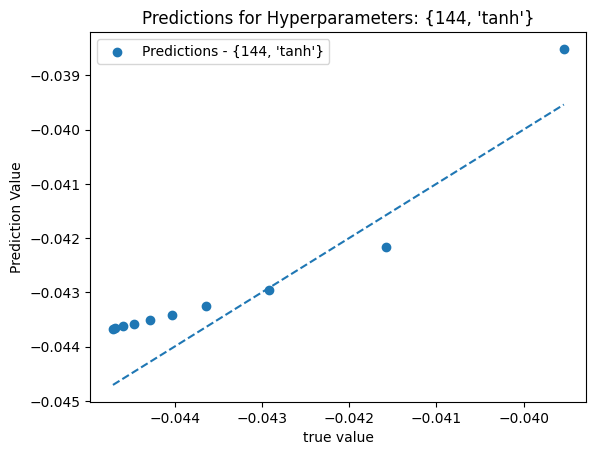

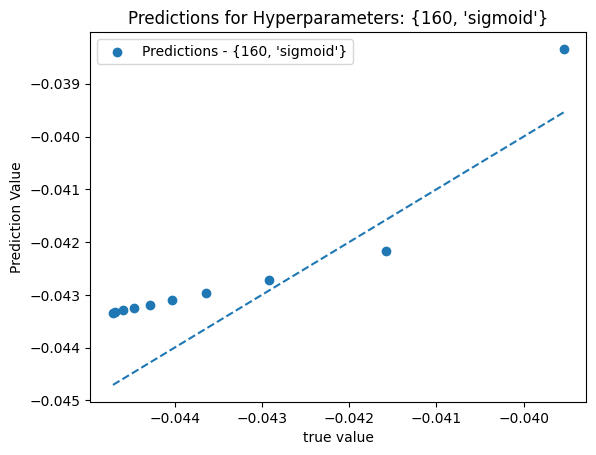

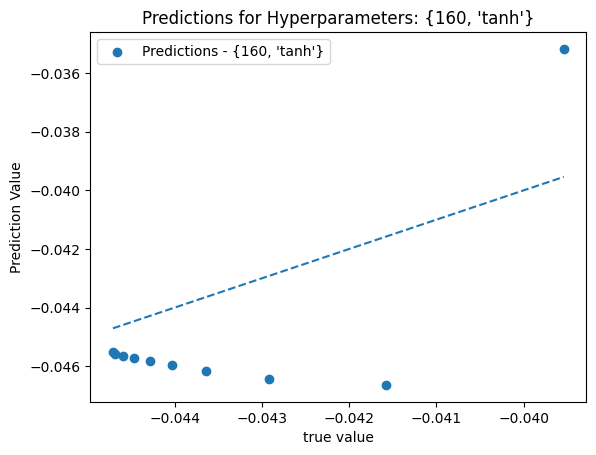

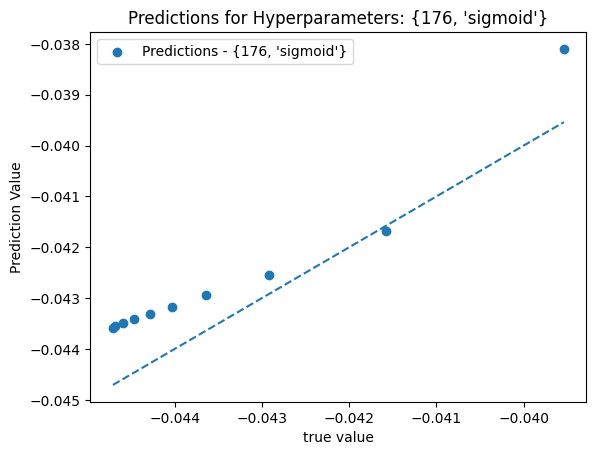

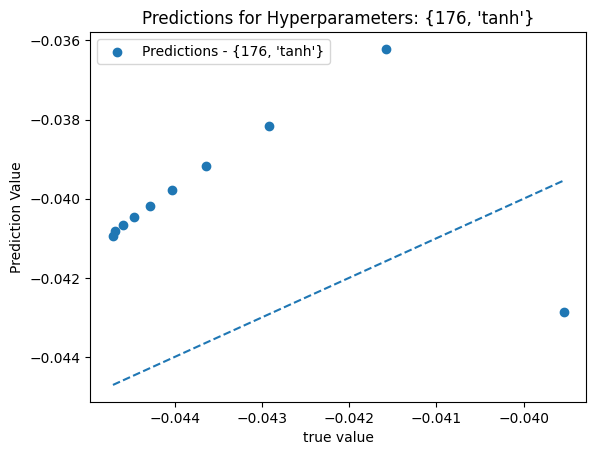

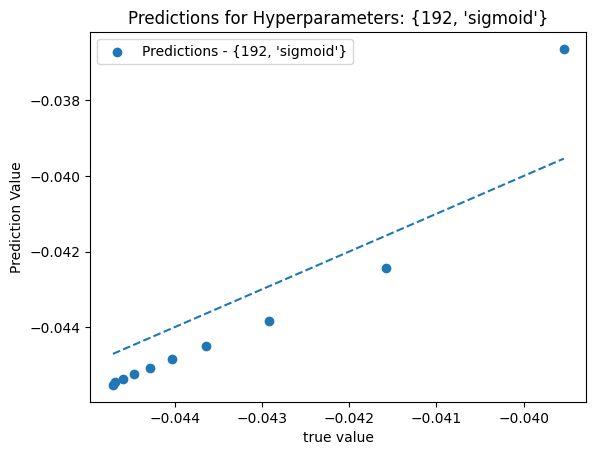

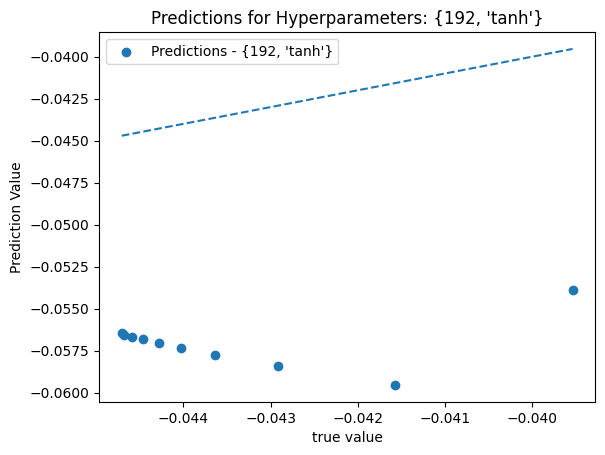

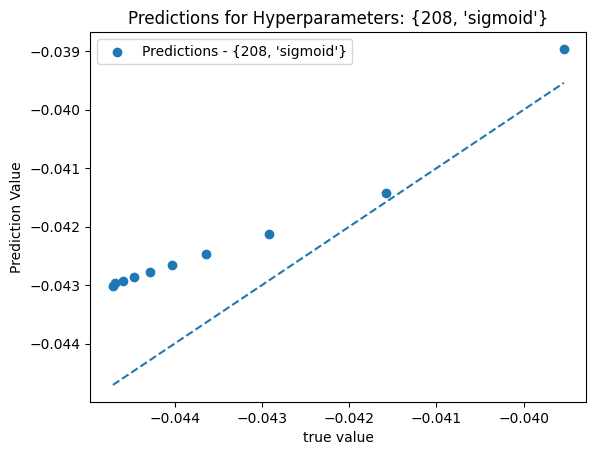

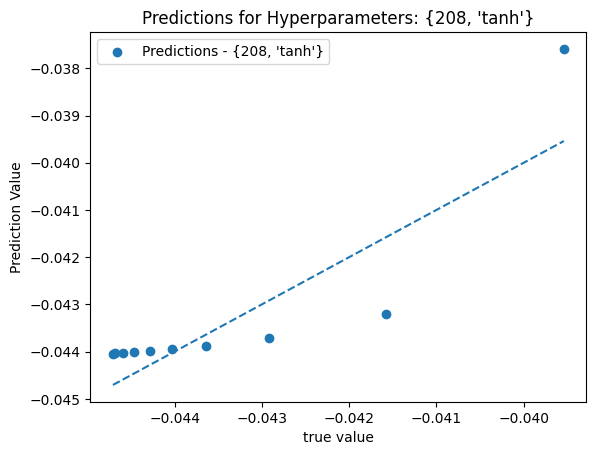

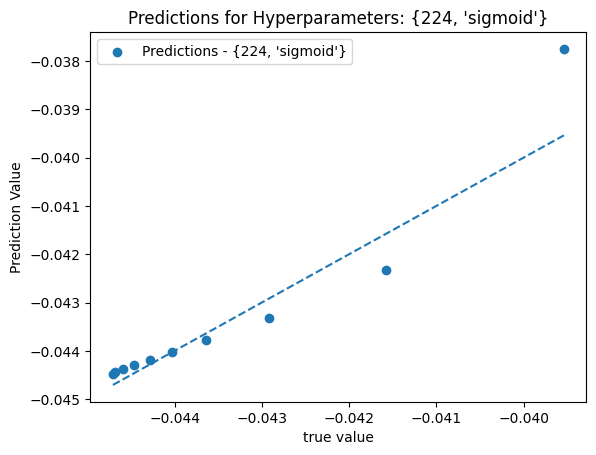

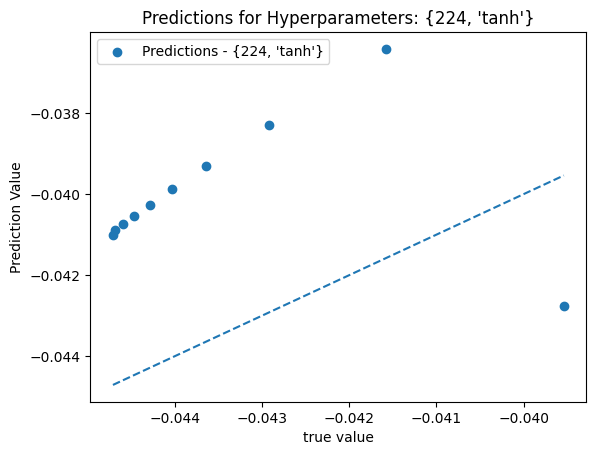

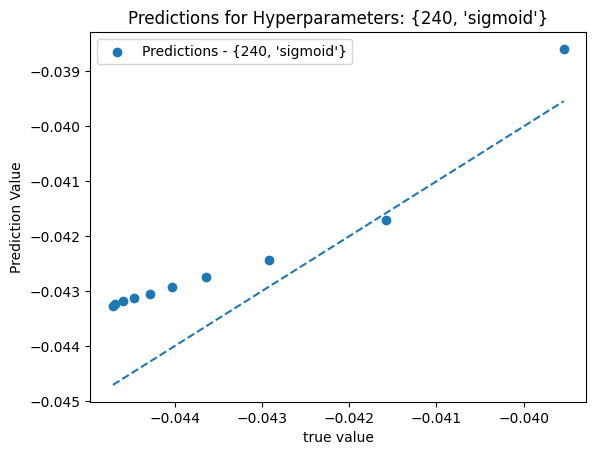

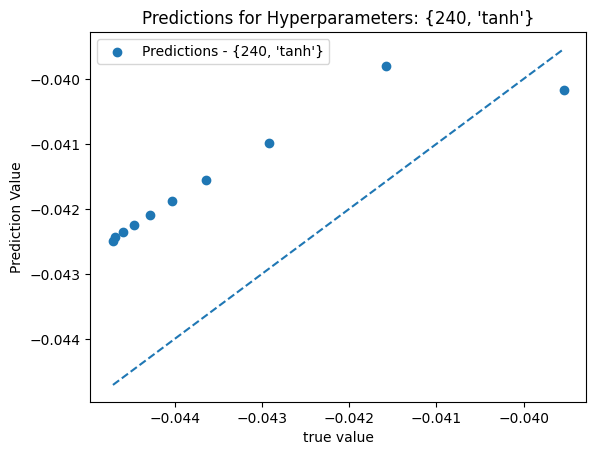

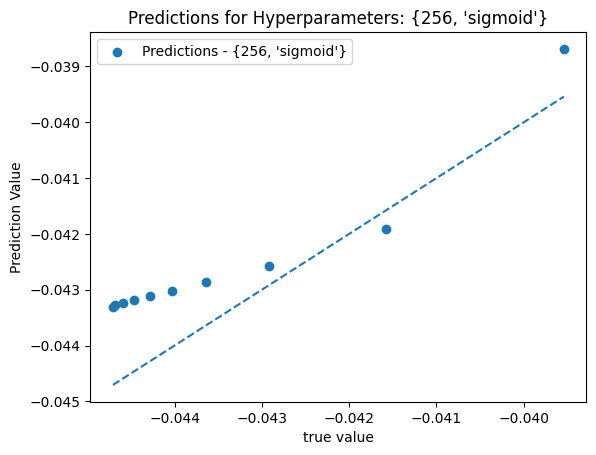

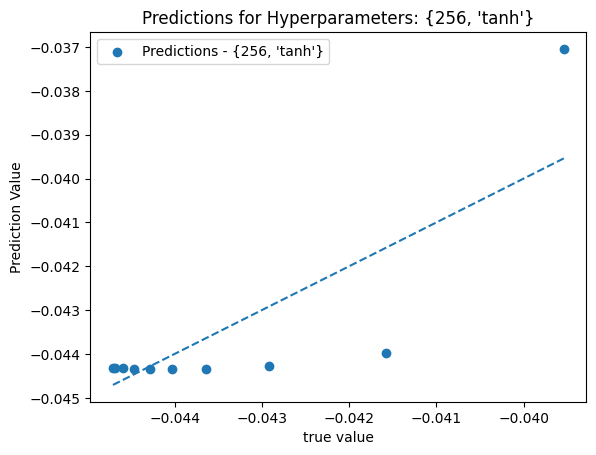

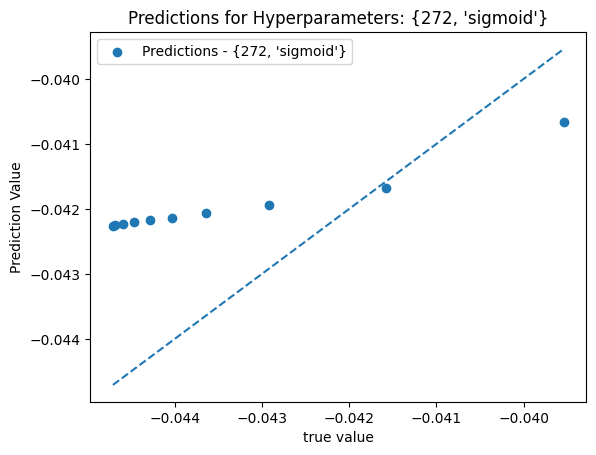

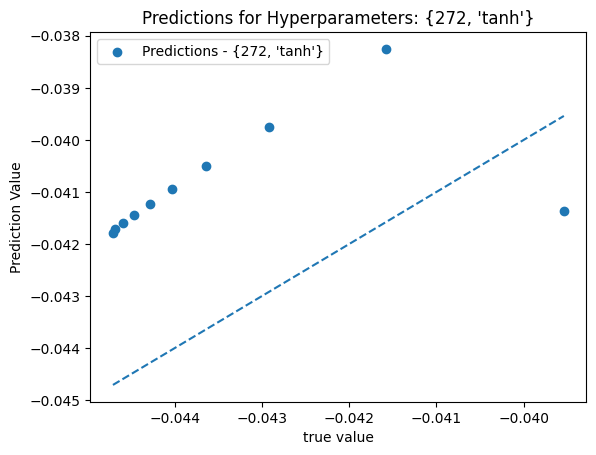

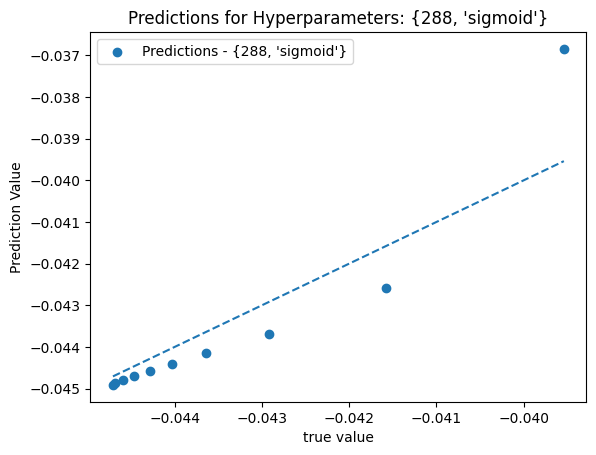

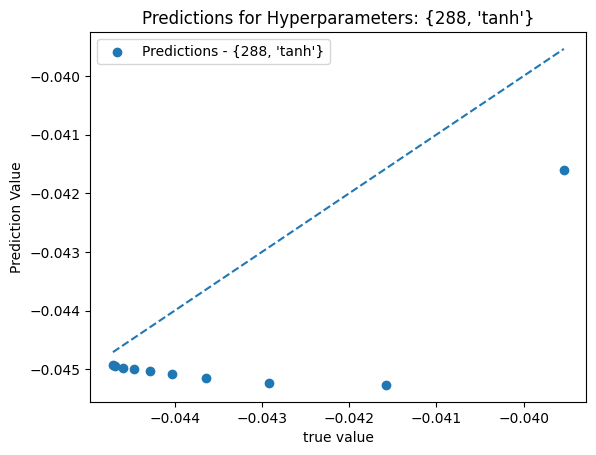

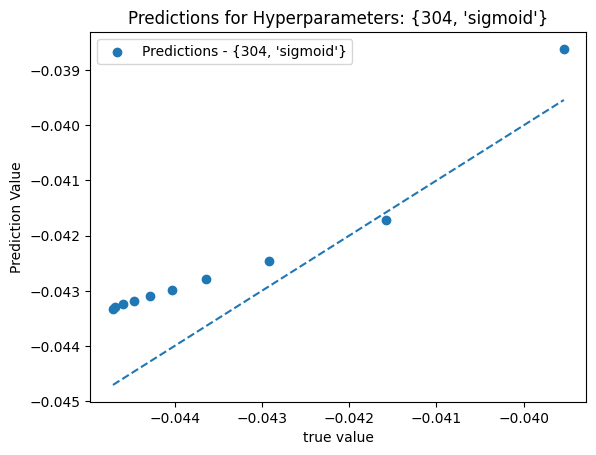

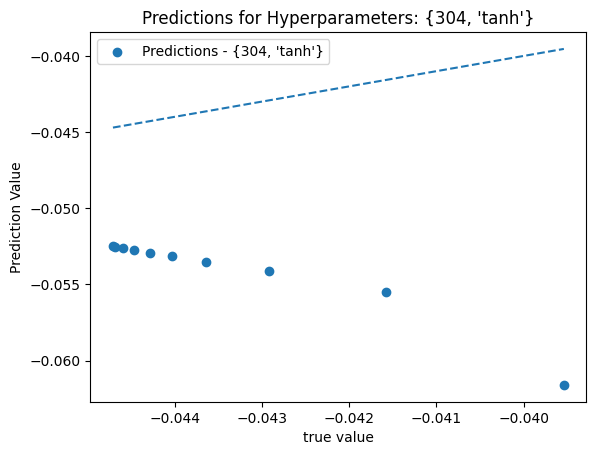

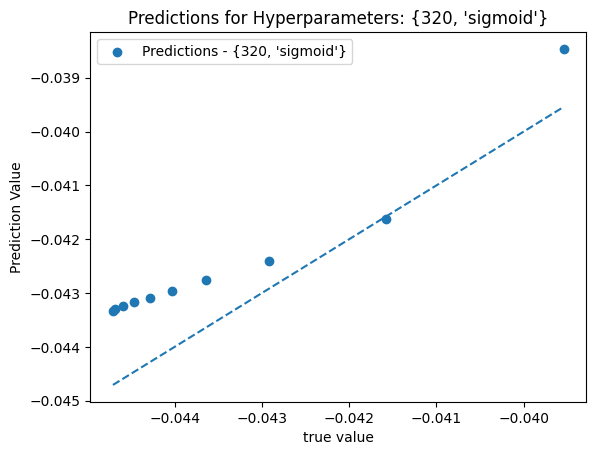

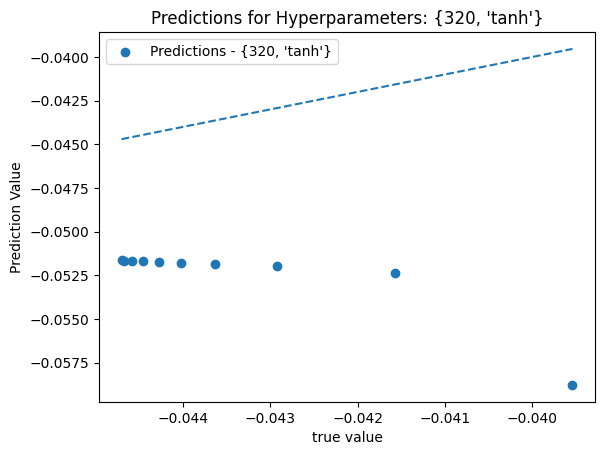

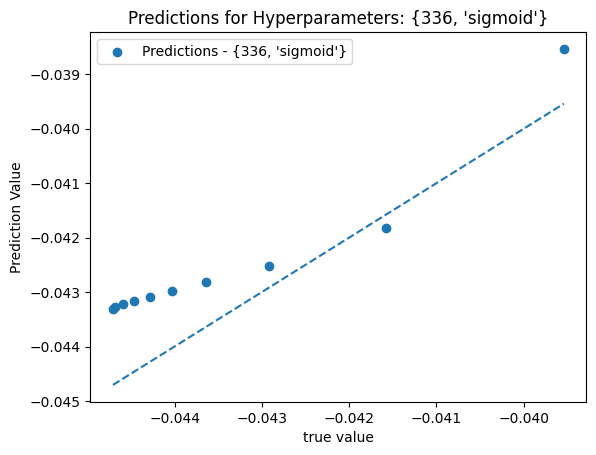

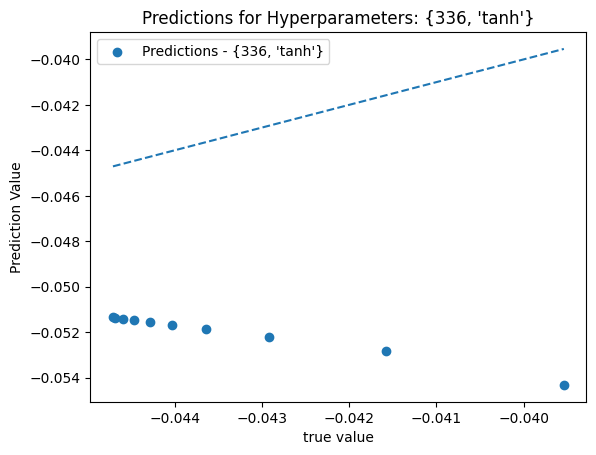

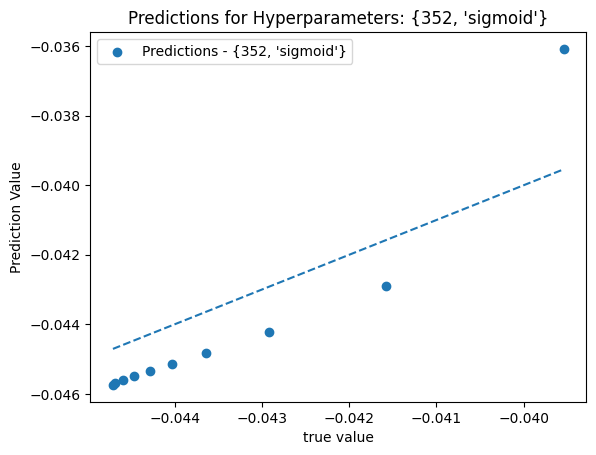

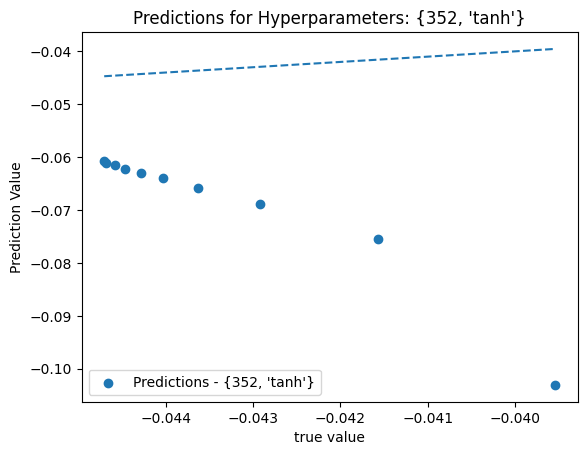

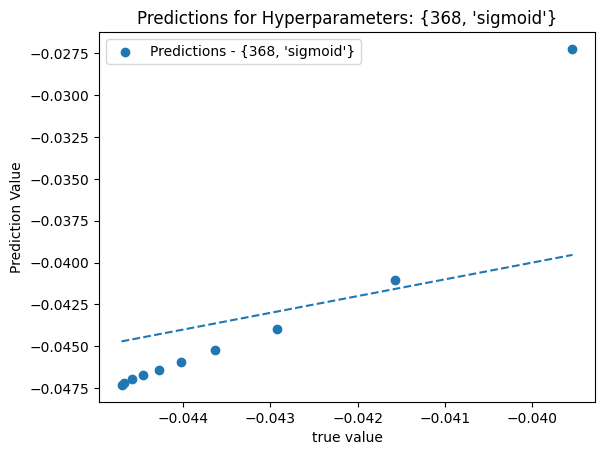

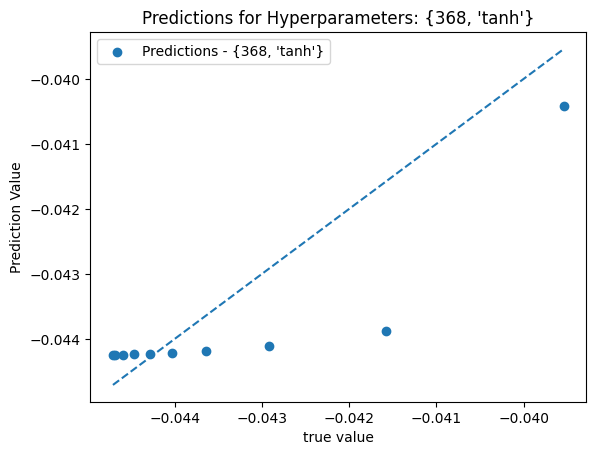

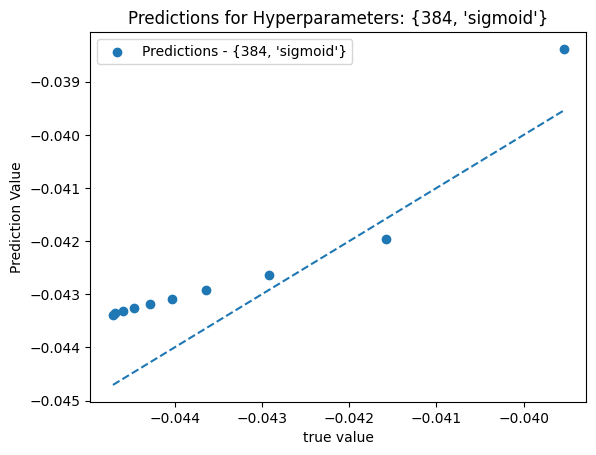

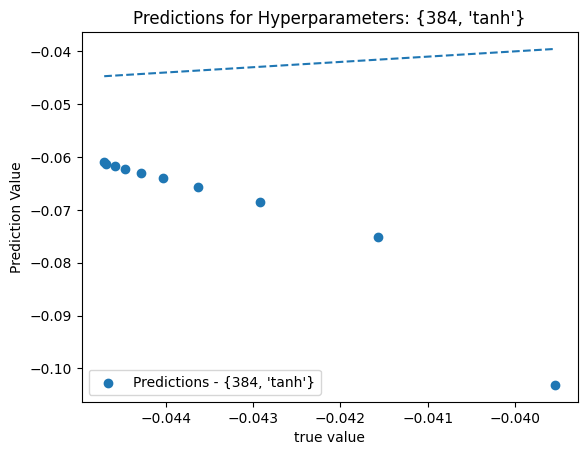

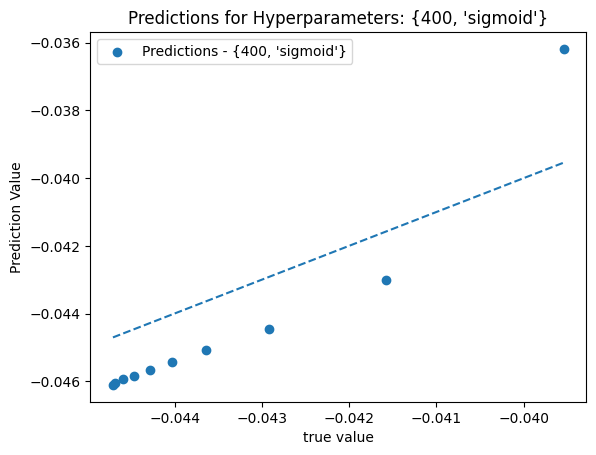

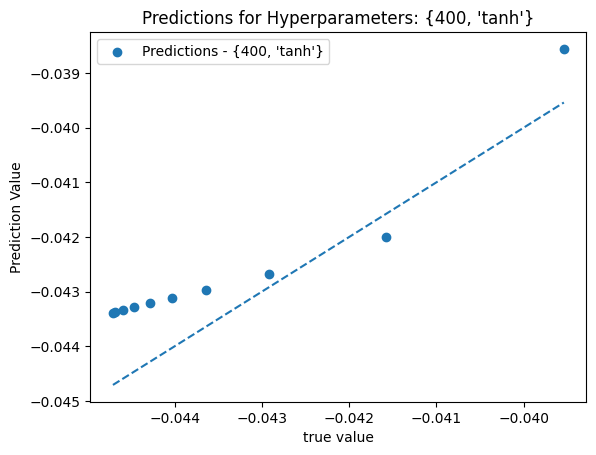

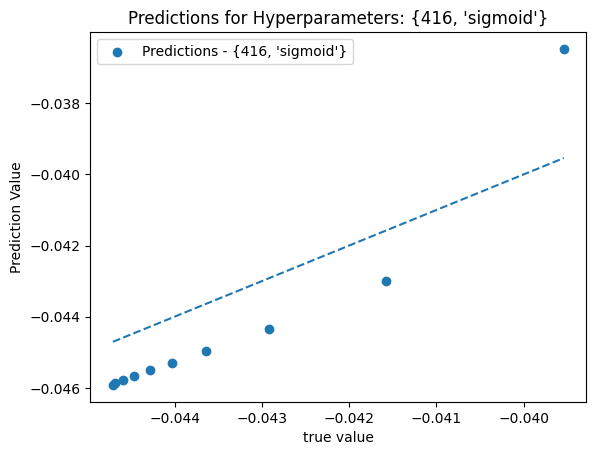

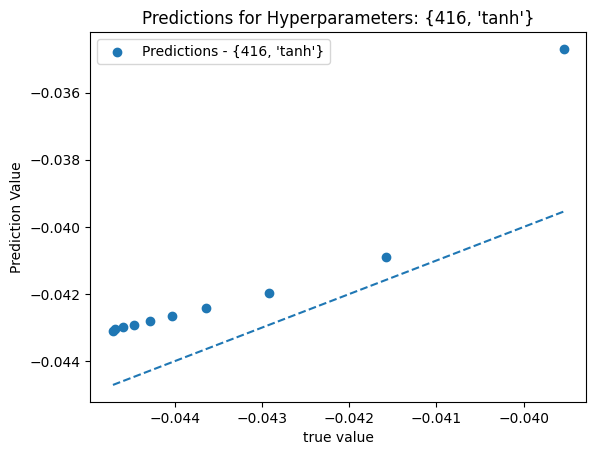

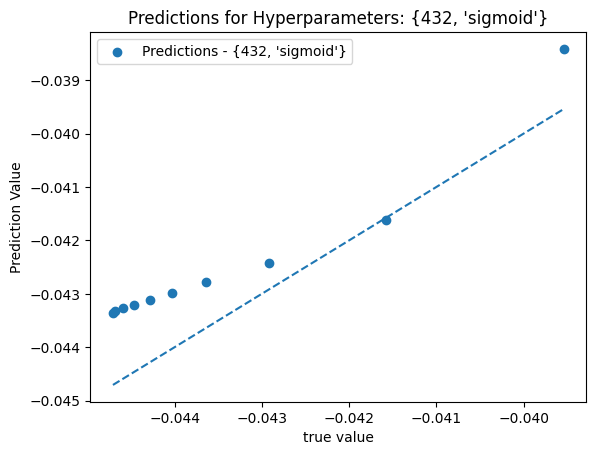

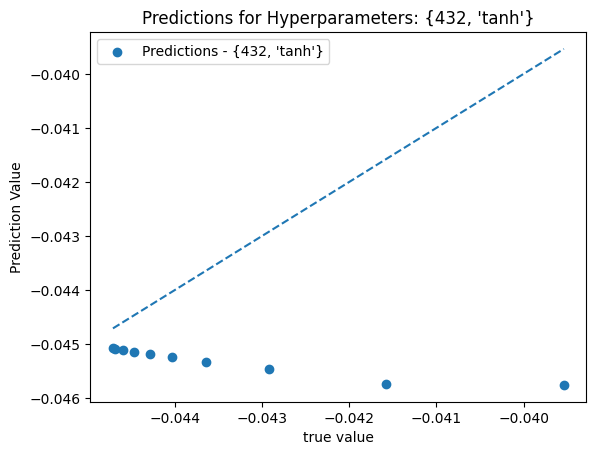

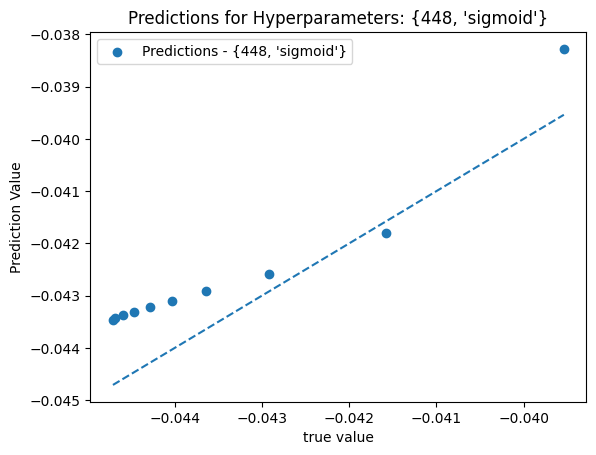

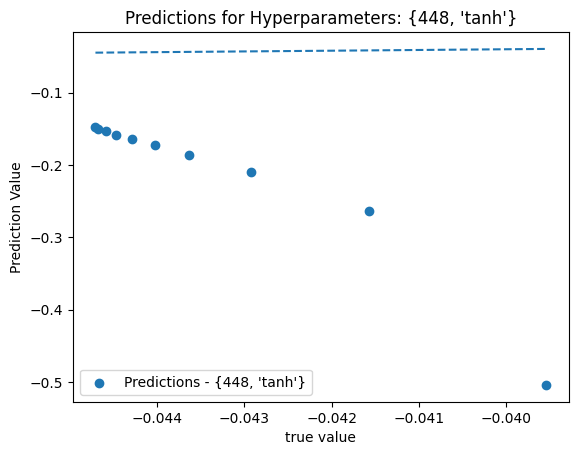

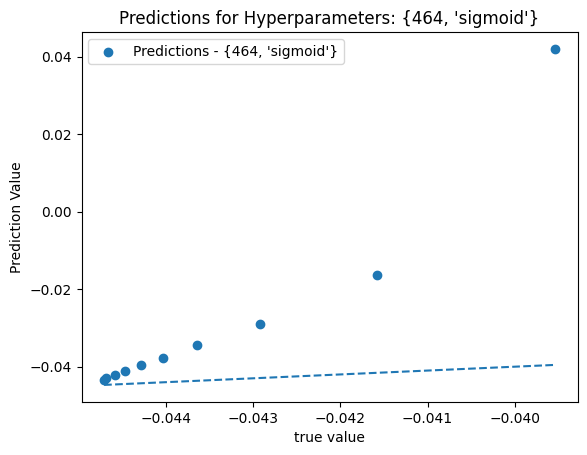

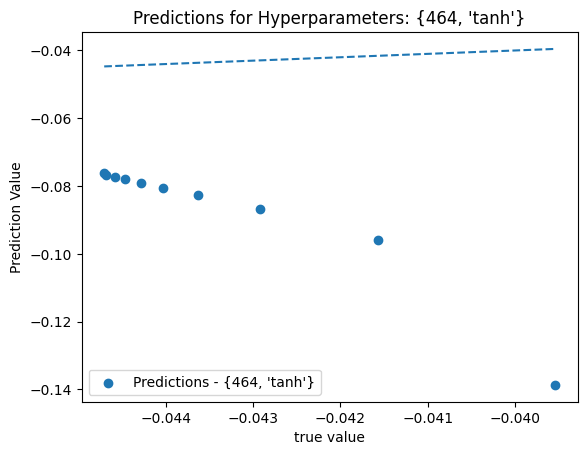

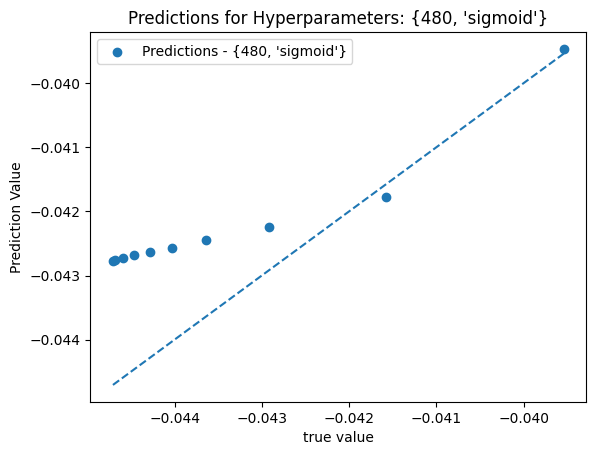

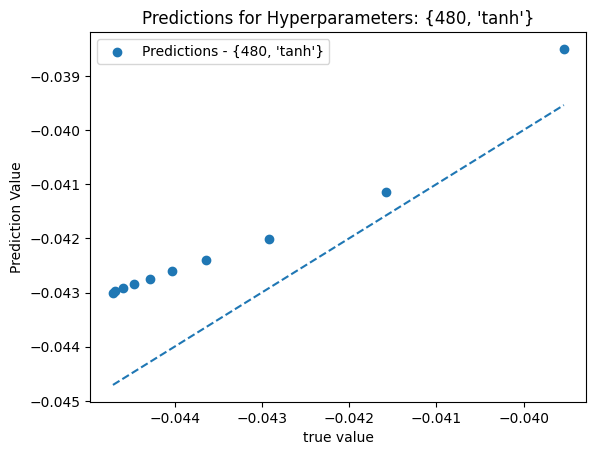

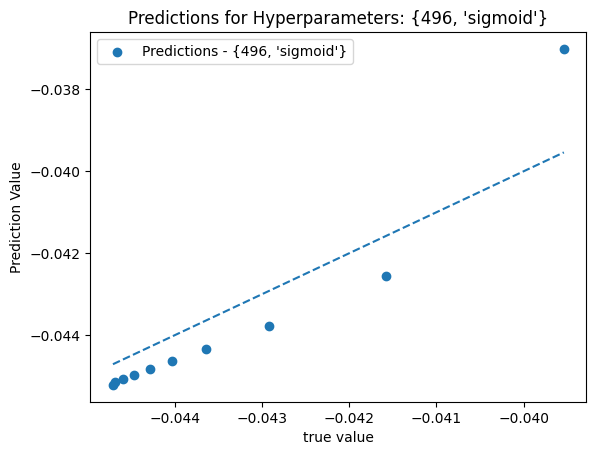

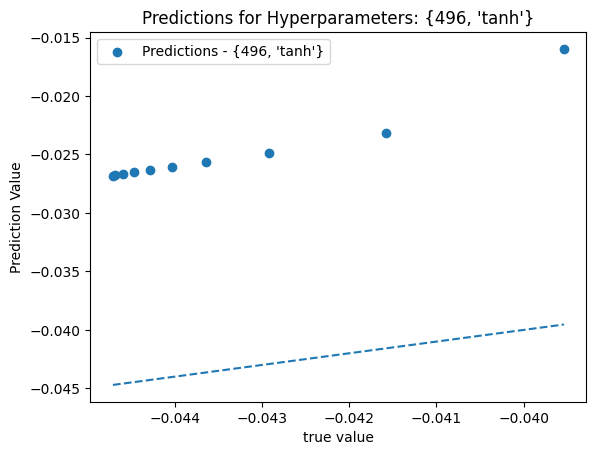

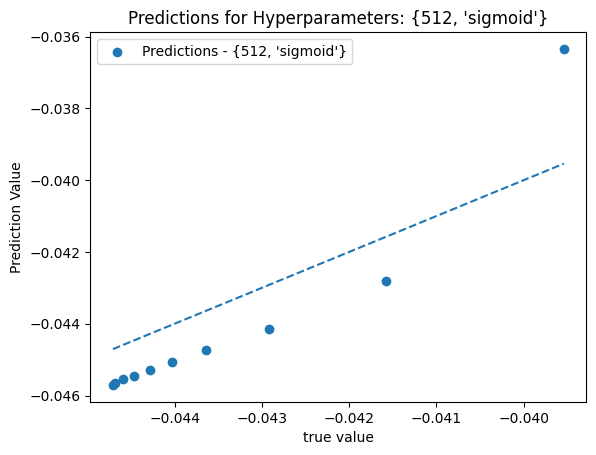

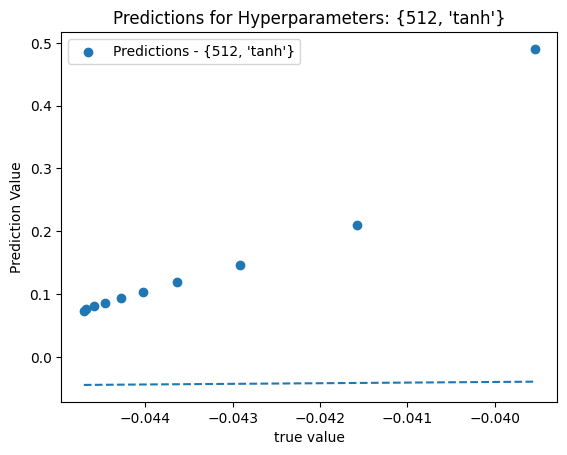

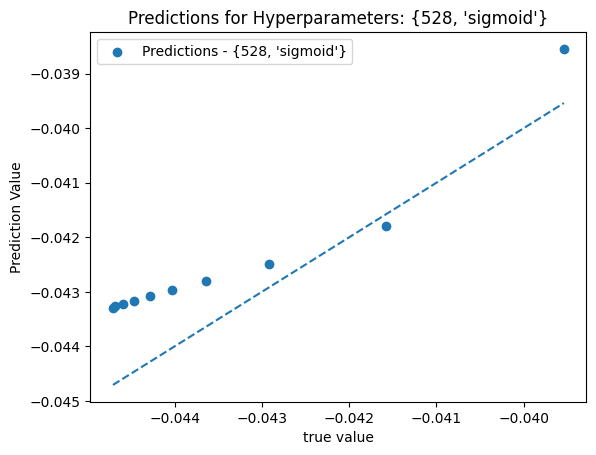

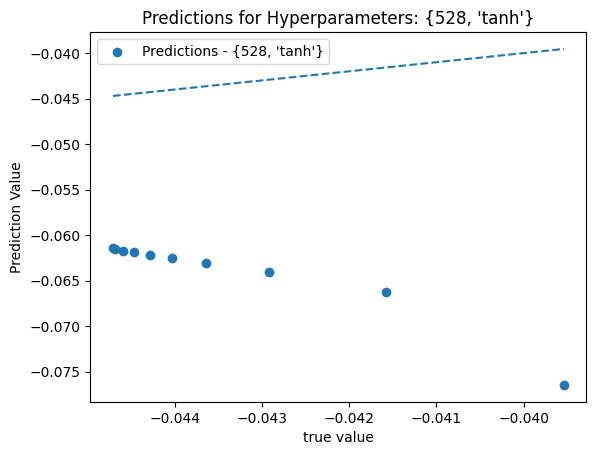

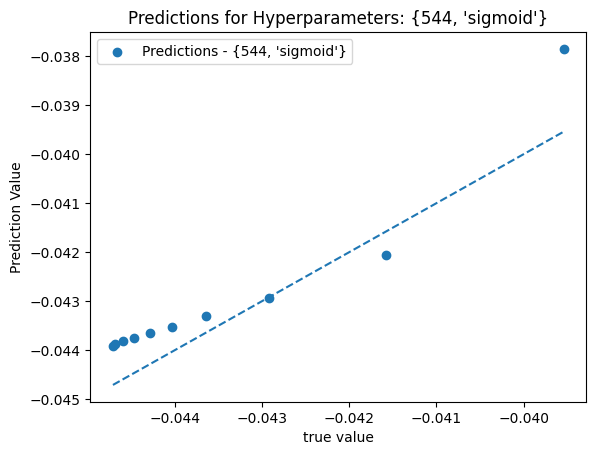

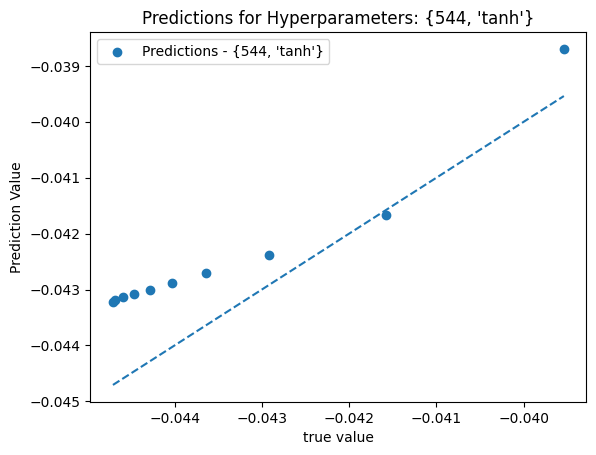

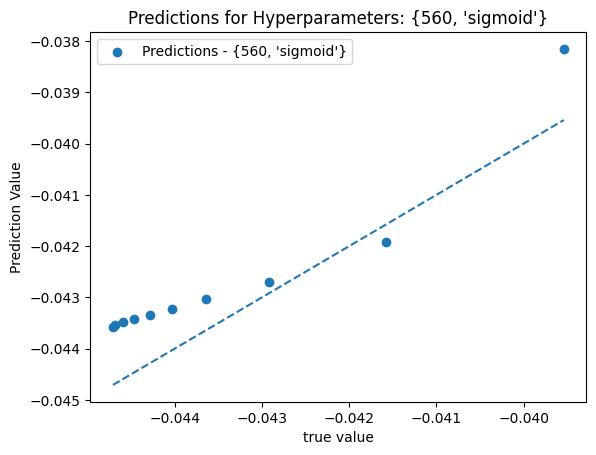

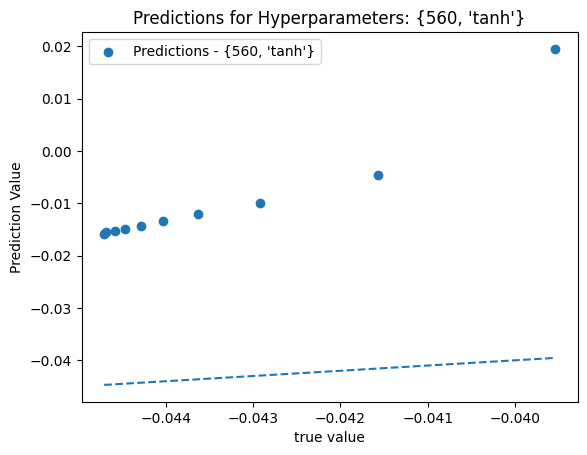

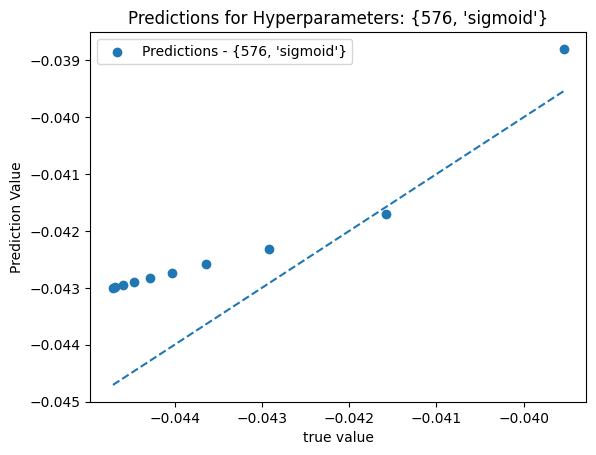

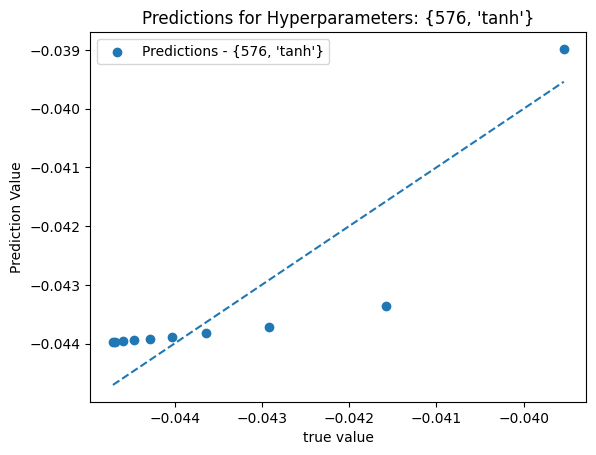

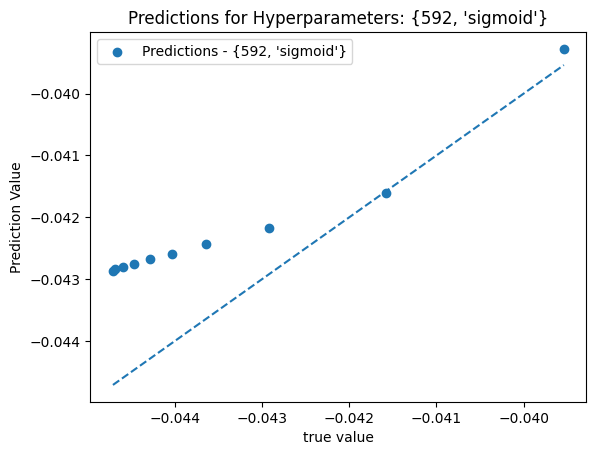

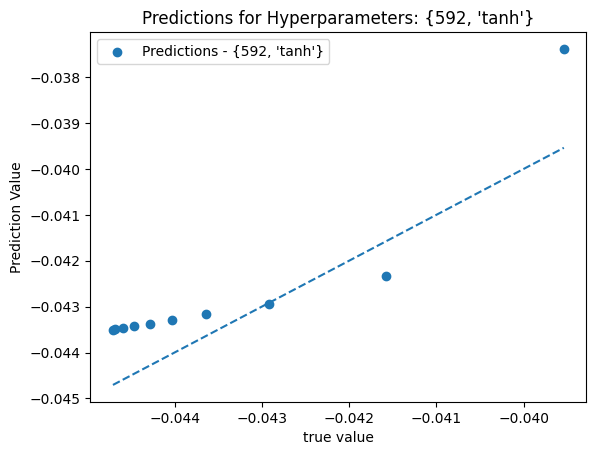

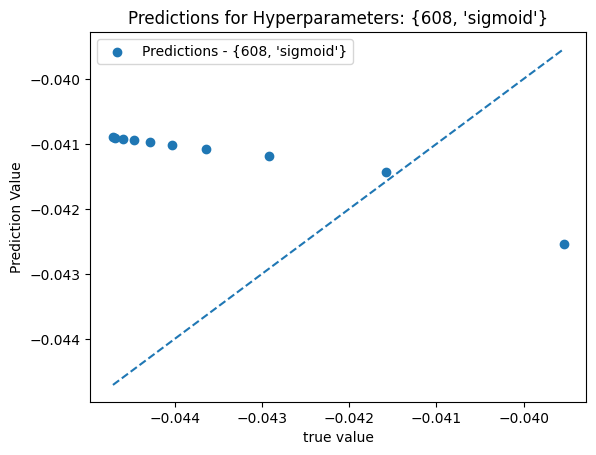

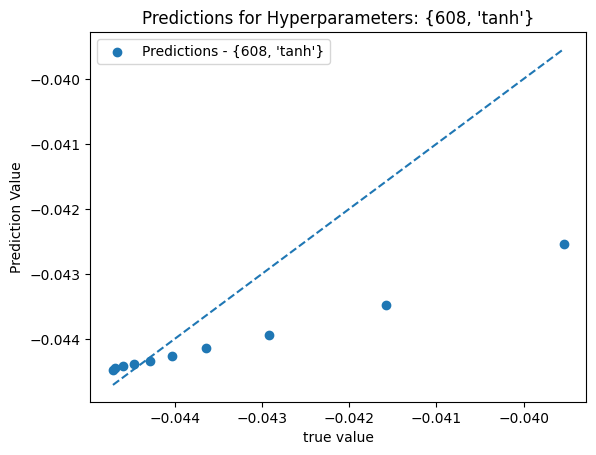

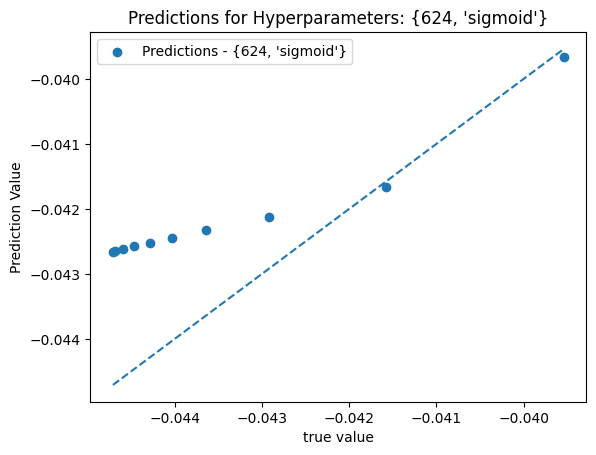

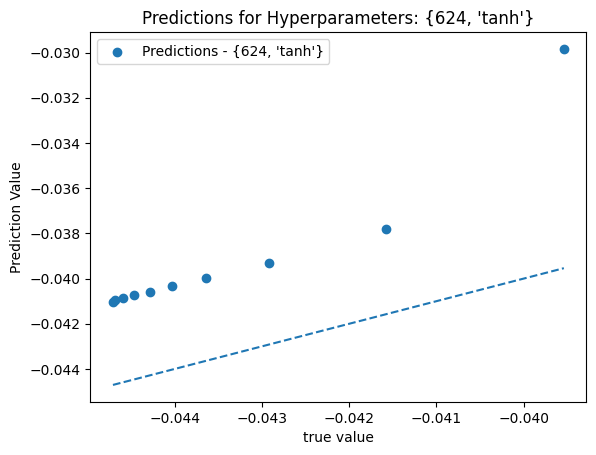

In [31]:
def buildmodel(units,act):
    model=keras.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(units,activation=act),
        keras.layers.Dense(1,)
    ])
    model.compile(
        'Adam',
        loss='huber')
    return model

actis=['sigmoid','tanh']

result_dt=[]

q=0
for i in range(16,640,16):
    for j in actis:
        model=buildmodel(i,j)
        model.fit(dataset,epochs=30)
        tmp=np.array(model.predict(size_list))
        result_dt.append({'params':{i,j},'predictions':tmp})

for i,results in enumerate(result_dt):
    plt.figure(i)
    plt.scatter(corr_list, results['predictions'], label=f"Predictions - {results['params']}")
    plt.title(f"Predictions for Hyperparameters: {results['params']}")
    plt.plot((min(corr_list),max(corr_list)),(min(corr_list),max(corr_list)),linestyle='--')
    plt.xlabel("true value")
    plt.ylabel("Prediction Value")
    plt.legend()
    plt.show()
    
    

In [7]:
#problems
#discontinuous/jumping graph.
    #decision tree to place the region of the graph then at the leaf use a second method to calculate exact energy.
    #i.e. H--Tree-->output=0 output 0 goes to model 0
    # P--Tree--> output= 2 goes to model 2 for prediction
    #this kinda implies that as we scale up to molecules, this would still matter
    #so trees to categorise the "strength" category of correlation --> orbital size
    #ANN to inteperpolate the category
    #what even the heck would be defining these categories though? from the atom example it seems
    #lets give it a go anyway worse that happens I waste some time.

In [8]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf 
import numpy as np

model_1 = tfdf.keras.DecisionForestModel(verbose=2, check_dataset=False)


model_1.fit(dataset)

# Predict initial categorization
initial_categories = model_1.predict(dataset)

print(model_1.summary())

NotFoundError: /home/stuart/miniconda3/envs/tf_env/lib/python3.11/site-packages/tensorflow_decision_forests/tensorflow/ops/inference/inference.so: undefined symbol: _ZN10tensorflow20OpKernelConstruction21CtxFailureWithWarningEPKciRKN4absl12lts_202308026StatusE

In [ ]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()


In [ ]:
from tfx_bsl import KMeans
n_clusters = 3
kmeans = KMeans(num_clusters=n_clusters)
kmeans.train(size_list)
clusters = kmeans.predict(size_list)

def create_model():
    model = tf.keras.Sequential([
        keras.layers.Dense(100, activation='tanh', input_shape=(1,)),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

models={}

for i in range(n_clusters):
    mask = clusters == i
    X_cluster, y_cluster = X[mask], y[mask]
    model = create_model()
    model.fit(X_cluster, y_cluster, epochs=100, verbose=0)
    models[i] = model
    
def predict_correlation_energy(orbital_size):
    normalized_size = normalize(tf.constant([orbital_size]))
    cluster = kmeans.predict(normalized_size)[0]
    return models[int(cluster)].predict([orbital_size])[0][0]

orbital_size = 5.0
predicted_energy = predict_correlation_energy(orbital_size)
print(f"Predicted correlation energy for orbital size {orbital_size}: {predicted_energy}")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
data = np.array(list(zip(size_list, corr_list)))
data_scaled=StandardScaler().fit_transform(data)






plt.scatter(data_scaled[:,0],data_scaled[:,1])

model=tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])
model.compile('adam',loss='mse')
model.fit(data_scaled[:,0],data_scaled[:,1],epochs=10)

predictions=model.predict(size_scaled)
predictions_new = StandardScaler.inverse_transform(predictions)


In [ ]:
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_scaled)

score = silhouette_score(data_scaled, kmeans.labels_)
print(f'Silhouette Score for 3 clusters: {score}')


labels = kmeans.labels_
plt.scatter(data_scaled[:, 0], data_scaled[: ,1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title(f'KMeans Clustering with 3 Clusters')
print(labels)

In [ ]:

model_1=keras.Sequential([
    keras.layers.Dense(48, activation='tanh')
    keras.layers.Dense(1)
])


model_2=keras.Sequential([
    keras.layers.Dense(48, activation='tanh')
    keras.layers.Dense(1)
])
